v05 - Early Stopping patience changed from 80 to 40

In [ ]:
# import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
import time

from IPython.display import Image
from keras.utils import plot_model

from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/arodrigues/opt/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/arodrigues/opt/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/arodrigues/opt/miniconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls "/content/drive/My Drive/datasets"
# df = pd.read_csv('/content/drive/My Drive/datasets/BVMF3.SA.csv',sep=';') # faz a leitura dos dados

df = pd.read_csv('BVMF3.SA.csv',sep=',') # faz a leitura dos dados

In [ ]:
df.head()

BVMF3.SA.Open  BVMF3.SA.High  BVMF3.SA.Low  BVMF3.SA.Close  \
0          11.90          12.10         11.80           12.07   
1            NaN            NaN           NaN             NaN   
2          12.07          12.10         11.75           11.80   
3          11.70          11.86         11.61           11.70   
4          11.63          11.65         11.33           11.54   

   BVMF3.SA.Volume  BVMF3.SA.Adjusted         Day  
0           5065.0           9.231656  2011-05-09  
1              NaN                NaN  2011-05-10  
2       14752500.0           9.025148  2011-05-11  
3        7371700.0           8.948664  2011-05-12  
4       12827000.0           8.826286  2011-05-13

In [ ]:
# df.columns = df.columns.str.lower() #change into lower case
df.rename(
    columns={
        'BVMF3.SA.Open':'open'
        ,'BVMF3.SA.High':'high'
        ,'BVMF3.SA.Low':'low'
        ,'BVMF3.SA.Close':'close'
        ,'BVMF3.SA.Volume':'volume'
        ,'BVMF3.SA.Adjusted':'adjusted'
        ,'Day':'day'}
    , inplace=True
)
df

open       high        low      close      volume   adjusted  \
0     11.900000  12.100000  11.800000  12.070000      5065.0   9.231656   
1           NaN        NaN        NaN        NaN         NaN        NaN   
2     12.070000  12.100000  11.750000  11.800000  14752500.0   9.025148   
3     11.700000  11.860000  11.610000  11.700000   7371700.0   8.948664   
4     11.630000  11.650000  11.330000  11.540000  12827000.0   8.826286   
...         ...        ...        ...        ...         ...        ...   
1623  23.389999  23.930000  23.240000  23.680000   7008800.0  23.599579   
1624  23.680000  23.680000  23.680000  23.680000         0.0  23.599579   
1625  23.870001  24.510000  23.830000  24.280001  13880900.0  24.197542   
1626  24.209999  24.590000  24.209999  24.490000  12842900.0  24.490000   
1627  24.400000  24.629999  24.059999  24.469999   2784700.0  24.469999   

             day  
0     2011-05-09  
1     2011-05-10  
2     2011-05-11  
3     2011-05-12  
4     2011-05-13  
...          ...  
1623  2017-11-17  
1624  2017-11-20  
1625  2017-11-21  
1626  2017-11-22  
1627  2017-11-23  

[1628 rows x 7 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 7 columns):
open        1602 non-null float64
high        1602 non-null float64
low         1602 non-null float64
close       1602 non-null float64
volume      1602 non-null float64
adjusted    1602 non-null float64
day         1628 non-null object
dtypes: float64(6), object(1)
memory usage: 89.2+ KB


In [ ]:
print('\033[1;31m Valores Faltantes antes do tratamento dos dados: \033[0;0m', '\n',df.isna().sum(), '\n')

 Valores Faltantes antes do tratamento dos dados:  
 open        26
high        26
low         26
close       26
volume      26
adjusted    26
day          0
dtype: int64 



In [ ]:
#Fill missed numerical data with mean:

df.update(df.fillna((np.around(np.mean(df),2))))
df

open       high        low      close       volume   adjusted  \
0     11.900000  12.100000  11.800000  12.070000      5065.00   9.231656   
1     13.430000  13.630000  13.230000  13.440000  12207226.91  12.110000   
2     12.070000  12.100000  11.750000  11.800000  14752500.00   9.025148   
3     11.700000  11.860000  11.610000  11.700000   7371700.00   8.948664   
4     11.630000  11.650000  11.330000  11.540000  12827000.00   8.826286   
...         ...        ...        ...        ...          ...        ...   
1623  23.389999  23.930000  23.240000  23.680000   7008800.00  23.599579   
1624  23.680000  23.680000  23.680000  23.680000         0.00  23.599579   
1625  23.870001  24.510000  23.830000  24.280001  13880900.00  24.197542   
1626  24.209999  24.590000  24.209999  24.490000  12842900.00  24.490000   
1627  24.400000  24.629999  24.059999  24.469999   2784700.00  24.469999   

             day  
0     2011-05-09  
1     2011-05-10  
2     2011-05-11  
3     2011-05-12  
4     2011-05-13  
...          ...  
1623  2017-11-17  
1624  2017-11-20  
1625  2017-11-21  
1626  2017-11-22  
1627  2017-11-23  

[1628 rows x 7 columns]

In [ ]:
print('\033[1;31m Valores Duplicados:', '\n \033[0;0m', df[df.duplicated()], '\n')

 Valores Duplicados: 
  Empty DataFrame
Columns: [open, high, low, close, volume, adjusted, day]
Index: [] 



In [ ]:
df.describe()

open         high          low        close        volume  \
count  1628.000000  1628.000000  1628.000000  1628.000000  1.628000e+03   
mean     13.432107    13.630713    13.234337    13.438077  1.220723e+07   
std       3.734740     3.763399     3.701464     3.739152  9.645915e+06   
min       7.850000     8.060000     7.500000     7.800000  0.000000e+00   
25%      10.730000    10.937500    10.540000    10.727500  7.568475e+06   
50%      12.130000    12.295000    11.970000    12.150000  1.053945e+07   
75%      15.620000    15.885000    15.390000    15.642500  1.436538e+07   
max      25.299999    25.799999    24.879999    25.250000  2.072703e+08   

          adjusted  
count  1628.000000  
mean     12.107023  
std       4.298520  
min       5.985022  
25%       9.174831  
50%      10.629043  
75%      15.164800  
max      25.164248

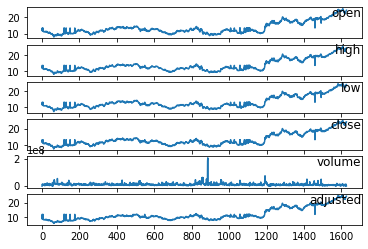

In [ ]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i=1
values = df.values

# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

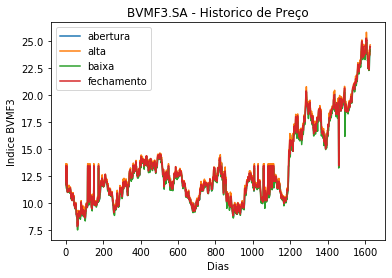

In [ ]:
plt.figure()
plt.plot(df["open"])
plt.plot(df["high"])
plt.plot(df["low"])
plt.plot(df["close"])
plt.title('BVMF3.SA - Historico de Preço')
plt.ylabel('Indice BVMF3')
plt.xlabel('Dias')
plt.legend(['abertura','alta','baixa','fechamento'], loc='upper left')
plt.show()

Now let’s check out the plot for volume :

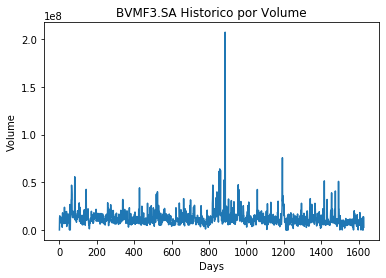

In [ ]:
plt.figure()
plt.plot(df["volume"])
plt.title('BVMF3.SA Historico por Volume')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

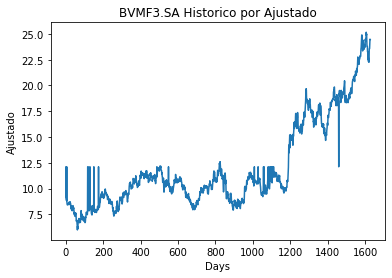

In [ ]:
plt.figure()
plt.plot(df["adjusted"])
plt.title('BVMF3.SA Historico por Ajustado')
plt.ylabel('Ajustado')
plt.xlabel('Days')
plt.show()

In [ ]:
df.drop(columns=['day','adjusted'],axis=1, inplace=True)

## Multivariate LSTM Forecast Model

### LSTM Data Preparation

**Após modelar os dados e avaliar o modelo com o conjunto de dados de treino, precisamos ter uma idéia de como será o comportamento do modelo com dados ainda não vistos por ele antes. Numa classificação normal ou problema de regressão, usaríamos o cross validation.**

**Com dados de séries temporais, a sequência de valores é importante. Um método simples que podemos usar é separar os dados ordenados entre conjuntos de treino e teste. O código abaixo calcula o índice do ponto de separação e separa os dados entre treinamento e teste.**

**O enunciado pede para prever 30 dias do valor de fechamento a partir do registro 1500 do dataset. Usaremos os primeiros 1500 registros para treino e os demais como teste.**

In [ ]:
# split into train and test sets
train, test = df.iloc[0:1500,:], df.iloc[1500:len(df),:]
print(len(train), len(test))

1500 128


In [ ]:
#### LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [ ]:
train.shape

(1500, 5)

In [ ]:
test.shape

(128, 5)

In [ ]:
X_train, y_train = train[:,0:-1], train[:,-1]

In [ ]:
X_test, y_test = train[:,0:-1], train[:,-1]

In [ ]:
print("\n X_train.shape:", X_train.shape, '\n', 'y_train.shape:', y_train.shape, '\n', 'X_test.shape:', X_test.shape, '\n', 'y_test.shape:', y_test.shape, '\n')


 X_train.shape: (1500, 4) 
 y_train.shape: (1500,) 
 X_test.shape: (1500, 4) 
 y_test.shape: (1500,) 



### Converting data to time-series and supervised learning problem

The first step is to prepare the dataset for the LSTM. This involves framing the dataset as a supervised learning problem and normalizing the input variables.

**LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.**

* **Batch Size** diz quantas amostras de entrada você deseja que a sua Rede Neural veja antes de atualizar os pesos. Digamos que você tenha 100 amostras (conjunto de dados de entrada) e deseje atualizar os pesos sempre que seu RN receber uma entrada. Nesse caso, o tamanho do lote seria 1 e o número total de lotes seria 100. Da mesma forma, se você deseja que sua rede atualize os pesos depois de ver todas as amostras, o tamanho do lote será 100 e o número de lotes será 1. O uso de um batch size muito pequeno reduz a velocidade do treinamento, por outro lado, o tamanho de um batch muito grande (como um conjunto de dados inteiro) reduz a capacidade dos modelos de generalizar para dados diferentes e também consome mais memória. Porém, são necessárias menos etapas para encontrar os mínimos para sua função objetivo. Então você precisa experimentar vários valores nos seus dados e encontrar o ponto ideal.

* **Time Steps** define quantas unidades no tempo você deseja que sua rede veja. Por exemplo, se você estava trabalhando em um problema de previsão de caracteres no qual possui um corpus de texto para treinar e decide alimentar 6 caracteres de sua rede de cada vez. Então, seu passo de tempo é 6. No nosso caso, usaremos 30 como Time Steps, ou seja, analisaremos 1 mês de dados para prever o preço dos próximos dias. 

* **Features** é o número de atributos usados para representar cada etapa do tempo. Considere o exemplo de previsão de caracteres acima e suponha que você use um vetor one-hot encoded 100 para representar cada caractere. O tamanho das features aqui é 4.

A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica na forma de: [samples, time steps, features].

Atualmente, nossos dados estão no formato: [samples, features] e estamos estruturando o problema como uma etapa única para cada amostra. Podemos transformar os dados preparados de entrada de treino e teste na estrutura esperada usando numpy.reshape() do seguinte modo:

In [ ]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("Tamanho da Série i/o (x, y)",x.shape,y.shape)
    return x, y

‘y_col_index’ é o índice da sua coluna de saída. Agora, suponha que, após a conversão de dados em um formato de aprendizado supervisionado, como mostrado acima, você tenha 41 amostras no conjunto de dados de treinamento, mas o tamanho do lote seja 20, será necessário aparar (trimmar) o conjunto de treinamento para remover as amostras ímpares deixadas de fora.

In [ ]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    print("Tamanho da Série i/o antes do trim:", mat.shape)
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        print("Tamanho da Série i/o depois do trim:", mat[:-no_of_rows_drop].shape)
        return mat[:-no_of_rows_drop]
    else:
        print("Tamanho da Série i/o depois do trim:", mat.shape)
        return mat

In [ ]:
TIME_STEPS = 30
BATCH_SIZE = 20
EPOCHS = 300

In [ ]:
x_t, y_t = build_timeseries(X_train, 3)

dim_0 1470
Tamanho da Série i/o (x, y) (1470, 30, 4) (1470,)


In [ ]:
x_t = trim_dataset(x_t, BATCH_SIZE)

Tamanho da Série i/o antes do trim: (1470, 30, 4)
Tamanho da Série i/o depois do trim: (1460, 30, 4)


In [ ]:
y_t = trim_dataset(y_t, BATCH_SIZE)

Tamanho da Série i/o antes do trim: (1470,)
Tamanho da Série i/o depois do trim: (1460,)


In [ ]:
x_temp, y_temp = build_timeseries(X_test, 3)

dim_0 1470
Tamanho da Série i/o (x, y) (1470, 30, 4) (1470,)


In [ ]:
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

Tamanho da Série i/o antes do trim: (1470, 30, 4)
Tamanho da Série i/o depois do trim: (1460, 30, 4)
Tamanho da Série i/o antes do trim: (1470,)
Tamanho da Série i/o depois do trim: (1460,)


In [ ]:
# # reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train.values, (X_train.values.shape[0], 1, X_train.values.shape[1]))
# X_test = np.reshape(X_test.values, (X_test.values.shape[0], 1, X_test.values.shape[1]))

In [ ]:
print("\n", "x_t.shape:", x_t.shape, "\n", "y_t.shape:", y_t.shape,"\n", "x_val.shape:", x_val.shape, "\n", "y_val.shape:", y_val.shape, "\n", "x_test_t.shape:", x_test_t.shape, '\n', "y_test_t.shape:", y_test_t.shape)


 x_t.shape: (1460, 30, 4) 
 y_t.shape: (1460,) 
 x_val.shape: (730, 30, 4) 
 y_val.shape: (730,) 
 x_test_t.shape: (730, 30, 4) 
 y_test_t.shape: (730,)


### Define and Fit Model

In [ ]:
def create_model():
    
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(
        100
        ,batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])
        ,dropout=0.0
        ,recurrent_dropout=0.0
        ,stateful=True
        ,return_sequences=True
        ,kernel_initializer='random_uniform'
        ,activation='relu'
    ))
#     lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(
        50
        , dropout=0.0
        , return_sequences=True
        ,activation='relu'
    ))
#     lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(
        25
        , dropout=0.0
        ,activation='relu' 
    ))
#     lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(
        20
        ,activation='relu'
    ))
    lstm_model.add(Dense(
        20
        ,activation='relu'
    ))
    lstm_model.add(Dense(
        1
#         ,activation='sigmoid'
    ))
#     optimizer = optimizers.RMSprop(lr=params["lr"])
#     optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    optimizer = optimizers.Adam()
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
#     lstm_model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    print(lstm_model.summary())
    return lstm_model

In [ ]:
model = create_model()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (20, 30, 100)             42000     
_________________________________________________________________
lstm_2 (LSTM)                (20, 30, 50)              30200     
_________________________________________________________________
lstm_3 (LSTM)                (20, 25)                  7600      
_________________________________________________________________
dense_1 (Dense)              (20, 20)                  520       
_________________________________________________________________
dense_2 (Dense)              (20, 20)                  420       
_________________________________________________________________
dense_3 (Dense)              (20, 1)                   21        
Total params: 80,761
Trainable params: 80,761
Non-trainable params: 0


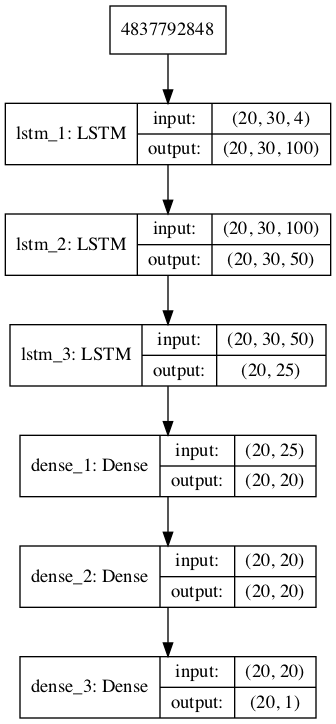

In [37]:
plot_model(model, to_file='ex_9.png', show_shapes=True, show_layer_names=True)
Image('ex_9.png')

In [ ]:
es = EarlyStopping(
    monitor='val_loss'
    , mode='min'
    , verbose=1
    ,patience=40
    , min_delta=0.0001
)

In [ ]:
mcp = ModelCheckpoint( 
    "best_model_v05.h5"
    , monitor='val_loss'
    , verbose=1
    ,save_best_only=True
    , save_weights_only=False
    , mode='min'
    , period=1
)

In [ ]:
history = model.fit(
    x_t
    , y_t
    , epochs=EPOCHS
    , verbose=1
    , batch_size=BATCH_SIZE
    ,shuffle=False
    ,validation_data=(trim_dataset(x_val, BATCH_SIZE),trim_dataset(y_val, BATCH_SIZE))
    ,callbacks=[es, mcp]
)

Tamanho da Série i/o antes do trim: (730, 30, 4)
Tamanho da Série i/o depois do trim: (720, 30, 4)
Tamanho da Série i/o antes do trim: (730,)
Tamanho da Série i/o depois do trim: (720,)
Instructions for updating:
Use tf.cast instead.
Train on 1460 samples, validate on 720 samples
Epoch 1/300
1460/1460 [==============================] - 13s 9ms/step - loss: 0.0166 - val_loss: 0.0292

Epoch 00001: val_loss improved from inf to 0.02917, saving model to best_model_v05.h5
Epoch 2/300
1460/1460 [==============================] - 11s 8ms/step - loss: 0.0186 - val_loss: 0.0209

Epoch 00002: val_loss improved from 0.02917 to 0.02086, saving model to best_model_v05.h5
Epoch 3/300
1460/1460 [==============================] - 9s 6ms/step - loss: 0.0134 - val_loss: 0.0168

Epoch 00003: val_loss improved from 0.02086 to 0.01681, saving model to best_model_v05.h5
Epoch 4/300
1460/1460 [==============================] - 9s 6ms/step - loss: 0.0111 - val_loss: 0.0161

Epoch 00004: val_loss improved from

In [ ]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Erro ", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Tamanho da Série i/o antes do trim: (730, 30, 4)
Tamanho da Série i/o depois do trim: (720, 30, 4)
Tamanho da Série i/o antes do trim: (730,)
Tamanho da Série i/o depois do trim: (720,)
Erro  0.0014001500717974167 (720,) (720,)
[0.25775456 0.25846612 0.25201112 0.254244   0.27478033 0.28668696
 0.30192098 0.31408054 0.3174157  0.32209298 0.32024157 0.33293352
 0.33250517 0.32467335 0.32616517]
[0.2492212  0.24065422 0.24065422 0.26479753 0.27959504 0.30685361
 0.30685361 0.3115265  0.31931467 0.30919006 0.34345797 0.31386295
 0.31074769 0.31775703 0.31074769]


In [ ]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3]
#y_pred_org =  min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * scaler.data_range_[3]) + scaler.data_min_[3]
#y_test_t_org = min_max_scaler.inverse_transform(y_test_t)

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[20.180464 20.185324 20.141235 20.156487 20.29675  20.378073 20.48212
 20.56517  20.58795  20.619896 20.60725  20.693935 20.69101  20.63752
 20.647709]
[20.12218082 20.06366835 20.06366835 20.22856712 20.32963411 20.51581013
 20.51581013 20.54772602 20.60091917 20.53176808 20.76581794 20.56368397
 20.54240671 20.59028054 20.54240671]


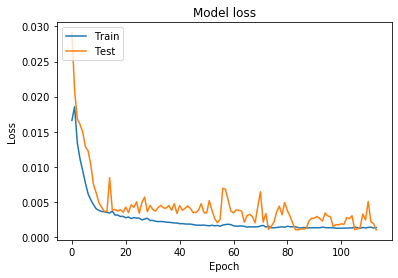

In [ ]:
# Visualize the training data
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# load the saved best model from above
saved_model = load_model( 'best_model_v05.h5') 
print(saved_model)

In [ ]:
y_pred_train = saved_model.predict(trim_dataset(x_t, BATCH_SIZE), batch_size=BATCH_SIZE)

Tamanho da Série i/o antes do trim: (1460, 30, 4)
Tamanho da Série i/o depois do trim: (1460, 30, 4)


In [ ]:
y_pred_train =y_pred_train.flatten()
y_pred_train_plot = (y_pred_train * scaler.data_range_[3]) + scaler.data_min_[3]
y_train_plot = (y_t * scaler.data_range_[3]) + scaler.data_min_[3]

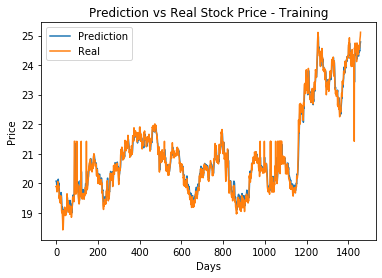

In [ ]:
plt.figure()
plt.plot(y_pred_train_plot)
plt.plot(y_train_plot)
plt.title('Prediction vs Real Stock Price - Training')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left') 
plt.show()

In [ ]:
y_pred_test = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred_test = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred_test)
print("\n Error is", error, y_pred_test.shape, y_test_t.shape, "\n")
print(y_pred_test[0:15])
print(y_test_t[0:15])

Tamanho da Série i/o antes do trim: (730, 30, 4)
Tamanho da Série i/o depois do trim: (720, 30, 4)
Tamanho da Série i/o antes do trim: (720,)
Tamanho da Série i/o depois do trim: (720,)

 Error is 0.0014001500717974167 (720,) (720,) 

[0.25775456 0.25846612 0.25201112 0.254244   0.27478033 0.28668696
 0.30192098 0.31408054 0.3174157  0.32209298 0.32024157 0.33293352
 0.33250517 0.32467335 0.32616517]
[0.2492212  0.24065422 0.24065422 0.26479753 0.27959504 0.30685361
 0.30685361 0.3115265  0.31931467 0.30919006 0.34345797 0.31386295
 0.31074769 0.31775703 0.31074769]


In [ ]:
y_pred_test_plot = (y_pred_test * scaler.data_range_[3]) + scaler.data_min_[3]
y_test_plot = (y_test_t * scaler.data_range_[3]) + scaler.data_min_[3]

print(y_pred_test_plot[0:15])
print(y_test_plot[0:15])

[20.180464 20.185324 20.141235 20.156487 20.29675  20.378073 20.48212
 20.56517  20.58795  20.619896 20.60725  20.693935 20.69101  20.63752
 20.647709]
[20.12218082 20.06366835 20.06366835 20.22856712 20.32963411 20.51581013
 20.51581013 20.54772602 20.60091917 20.53176808 20.76581794 20.56368397
 20.54240671 20.59028054 20.54240671]


In [ ]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [ ]:
stime = time.time()

Término  0.0 minutes :  1.0 seconds


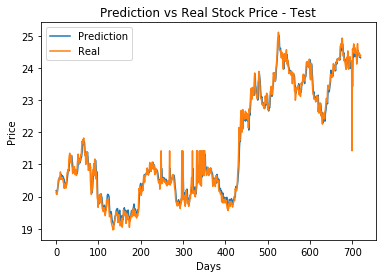

In [ ]:
# Visualize the prediction
plt.figure()
plt.plot(y_pred_test_plot)
plt.plot(y_test_plot)
plt.title('Prediction vs Real Stock Price - Test')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()

print_time("Término ", stime)

**References**

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/  

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/  

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/  

https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944  

https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/